In [29]:
import numpy as np

np.set_printoptions(
    suppress=True,
    linewidth=180
)

# Board generation

In [30]:
def generate_board(num_actions):
    import random
    actions = [
        {
            "id": i,
            "attackerCost": random.randint(1, 5),
            "defenderCost": random.randint(1, 5),
            "attackerProb": round(random.uniform(0.5, 0.98),2),
            "defenderProb": round(random.uniform(0.5, 0.98),2),
            "severity": random.randint(1,5),
        }
        for i in range(num_actions)
    ]
    for v in actions:
        v["risk"] = round(v["severity"] ** 2 * v["attackerProb"] * (1-v["defenderProb"]) * (v["defenderCost"] / v["attackerCost"]),2)
    return actions

# Utility matrix generation

In [31]:
def powerset(s):
    import itertools
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(1, len(s)+1))

In [32]:
def get_utility(attackerMoves, defenderMoves):
    defenderLabels = set([m["id"] for m in defenderMoves])
    return sum([
        move["severity"]**2 * move["attackerProb"]
        if move["id"] not in defenderLabels else
        move["severity"]**2 * move["attackerProb"] * (1-move["defenderProb"])
        for move in attackerMoves
    ])

In [33]:
def validate_cost(moves, cost_func, max_cost):
    return sum([cost_func(m) for m in moves]) <= max_cost

In [34]:
def remove_bad_columns(a):
    return np.delete(a, np.argwhere(np.all(a[..., :] == -999, axis = 0)), axis=1)

In [35]:
def generate_utility_matrices(
    board,
    attacker_cost_available,
    defender_cost_available,
    defender_knows_attacker_cost
):
    all_move_sets = list(powerset(board))
    attacker_utility_matrix = np.zeros((len(all_move_sets),len(all_move_sets)))
    defender_utility_matrix = np.zeros((len(all_move_sets),len(all_move_sets)))
    print(f"Found {len(all_move_sets)} move combinations ({len(all_move_sets) ** 2:,} for both)")

    for i, attacker_choice in enumerate(all_move_sets):
        for j, defender_choice in enumerate(all_move_sets):
            # if the attacker moveset is invalid
            if not validate_cost(attacker_choice, lambda x: x["attackerCost"], attacker_cost_available):
                # terrible attacker utility
                attacker_utility_matrix[i][j] = -999
                # if the defender moveset is also invalid
                if not validate_cost(defender_choice, lambda x: x["defenderCost"], defender_cost_available):
                    # terrible defender utility
                    defender_utility_matrix[i][j] = -999
                else:
                    # utility is dependent on whether the defender knows the attacker max cost or not
                    defender_utility_matrix[i][j] = -999 if defender_knows_attacker_cost else -get_utility(attacker_choice, defender_choice)
            else:
                # normal attacker utility otherwise
                attacker_utility_matrix[i][j] = get_utility(attacker_choice, defender_choice)
                # if defender moveset is invalid
                if not validate_cost(defender_choice, lambda x: x["defenderCost"], defender_cost_available):
                    # terrible defender utility
                    defender_utility_matrix[i][j] = -999
                else:
                    # normal defender utility otherwise
                    defender_utility_matrix[i][j] = -get_utility(attacker_choice, defender_choice)
    # return attacker_utility_matrix.transpose(), defender_utility_matrix
    return \
        remove_bad_columns(attacker_utility_matrix.transpose()), \
        remove_bad_columns(defender_utility_matrix)

# Optimization problem solver

In [36]:
def get_optimized_solution(util):
    import scipy.optimize
    
    # print(util.shape)

    c = np.zeros(util.shape[1]+1)
    c[0] = -1

    A_ub = np.ones((util.shape[0], util.shape[1] +1))
    A_ub[:,1:] = util*-1
    b_ub = np.zeros(util.shape[0])

    A_eq = np.ones((1, util.shape[1] + 1))
    A_eq[0][0] = 0
    b_eq = 1

    lb = np.zeros(util.shape[1]+1)
    lb[0] = -10000
    ub = np.ones(util.shape[1]+1)
    ub[0] = 10000
    bounds = np.asarray([lb, ub]).transpose()

    result = scipy.optimize.linprog(
        c=c,
        A_ub=A_ub,
        b_ub=b_ub,
        A_eq=A_eq,
        b_eq=b_eq,
        bounds=bounds,
        # options = {
        #     "tol": 0.001
        #     # "autoscale": True
        # }
        # method="simplex",
        method="highs",
        # method="interior-point",
        # options={"presolve":False},
        # callback = lambda x: zz.append(x.x)
    )
    if result.success:
        return result.x[1:]
    else:
        print(result)
        raise Exception("Couldn't find solution")

# get_optimized_solution(attacker_utility)

In [37]:
def get_average_solution(utility_matrix):
    x = utility_matrix.shape[1]
    return np.ones(x) / x

In [38]:
# def get_knapsack_solution(board, costFunc):
#     from ortools.algorithms import pywrapknapsack_solver
#     y_defender_strat = []
#     values = [x["severity"]**2 * x["attackerProb"] * (1-x["defenderProb"]) * (x["defenderCost"] / x["attackerCost"]) for x in board]
#     values = [int(x*1000) for x in values]

#     weights = [x["defenderCost"] for x in board]

#     solver = pywrapknapsack_solver.KnapsackSolver(pywrapknapsack_solver.KnapsackSolver.KNAPSACK_MULTIDIMENSION_BRANCH_AND_BOUND_SOLVER, "mySolver")
#     solver.Init(values, [weights], [10])
#     y = solver.Solve()
#     print(values)
#     used = [x for x in range(len(values)) if solver.BestSolutionContains(x)]
#     print(used)
#     print ([x for i, x in enumerate(weights) if i in used])

# Investigation

In [39]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [40]:
from tqdm.notebook import tqdm

x = []
y_attacker_best = []
y_attacker_average = []
y_defender_best = []
y_defender_average = []
for i in tqdm(range(1,11)):
# for i in [4]:
    x.append(i)
    board = generate_board(i)
    attacker_utility, defender_utility = generate_utility_matrices(
        board=board,
        attacker_cost_available=10,
        defender_cost_available=10,
        defender_knows_attacker_cost=False
    )

    # import scipy.io
    # scipy.io.savemat("../matlab/utility.mat", {
    #     "attacker_utility": attacker_utility,
    #     "defender_utility": defender_utility,
    # })
    # break
    
    attacker_optimal = get_optimized_solution(attacker_utility)
    attacker_optimal_value = (attacker_utility * attacker_optimal).sum(axis=1).max()
    attacker_average_value = (attacker_utility * get_average_solution(attacker_utility)).sum(axis=1).max()

    defender_optimal = get_optimized_solution(defender_utility)
    defender_optimal_value = (defender_utility * defender_optimal).sum(axis=1).min()
    defender_average_value = (defender_utility * get_average_solution(defender_utility)).sum(axis=1).min()

    y_attacker_best.append(attacker_optimal_value)
    y_attacker_average.append(attacker_average_value)
    
    y_defender_best.append(defender_optimal_value)
    y_defender_average.append(defender_average_value)

  0%|          | 0/10 [00:00<?, ?it/s]

Found 1 move combinations (1 for both)
Found 3 move combinations (9 for both)
Found 7 move combinations (49 for both)
Found 15 move combinations (225 for both)
Found 31 move combinations (961 for both)
Found 63 move combinations (3,969 for both)
Found 127 move combinations (16,129 for both)
Found 255 move combinations (65,025 for both)


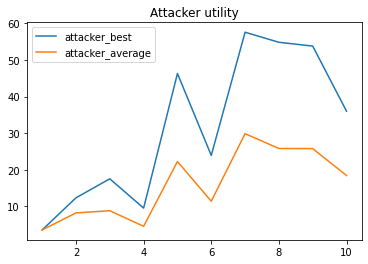

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.set_title("Attacker utility")
# ax.set_yscale("symlog")
# ax.yaxis.set_major_locator(plt.LogLocator(base=10, numticks=5))
# ax.yaxis.set_major_locator(plt.MaxNLocator(100))
line, = ax.plot(x, y_attacker_best, label="attacker_best")
line, = ax.plot(x, y_attacker_average, label="attacker_average")
ax.legend()


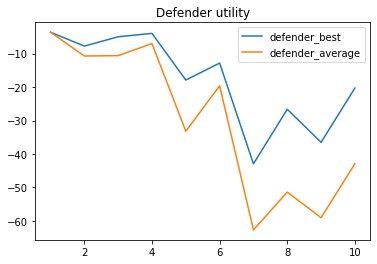

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)
ax.set_title("Defender utility")
# ax.set_yscale("symlog")
# ax.yaxis.set_major_locator(plt.LogLocator(base=10, numticks=5))
# ax.yaxis.set_major_locator(plt.MaxNLocator(100))
line, = ax.plot(x, y_defender_best, label="defender_best")
line, = ax.plot(x, y_defender_average, label="defender_average")
ax.legend()